In [165]:
# Import required libraries
import numpy as np
import pandas as pd
import sweetviz as sw
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import stanza
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [166]:
# convert to pandas dataframe
df = pd.read_json('Data/News_Category_Dataset_IS_course.json', lines=True)

In [167]:
df.shape

(148122, 6)

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148122 entries, 0 to 148121
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               148122 non-null  object        
 1   headline           147391 non-null  object        
 2   category           148122 non-null  object        
 3   short_description  147386 non-null  object        
 4   authors            148122 non-null  object        
 5   date               148122 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 6.8+ MB


In [169]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
1,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
2,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20
3,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",,2022-09-20
4,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19


In [170]:
print("Unique categories:",df['category'].nunique())

Unique categories: 15


In [171]:
# report = sw.analyze(df)

In [172]:
# report.show_notebook(layout='vertical', w=1200, h=1440, scale=1)

In [173]:
df1 = df.copy() #Backup

In [174]:
df = df.dropna()

In [175]:
# sort out datatypes
# date
df['date'] = pd.to_datetime(df['date'], unit='ms').dt.strftime('%Y')
# headline
df['headline'] = df['headline'].astype(str)
# authors
df['authors'] = df['authors'].astype(str)
# link
df['link'] = df['link'].astype(str)
# short_description
df['short_description'] = df['short_description'].astype(str)
# category as a category
df['category'] = df['category'].astype(str)

# Exploratory Data Analysis

## Missing values

In [176]:
# look for empty strings across all columns
(df == '').sum()

link                     0
headline                 3
category                 0
short_description    11390
authors              24164
date                     0
dtype: int64

In [177]:
((df == '').sum()  / df.shape[0]) * 100

link                  0.000000
headline              0.002046
category              0.000000
short_description     7.766527
authors              16.476765
date                  0.000000
dtype: float64

In [178]:
print(df[(df['authors'] == '') & (df['short_description'] == '') & (df['headline'] == '')].shape[0])
print(df[(df['authors'] == '') & (df['short_description'] == '')].shape[0])

0
2238


In [179]:
df[df['headline'] == '']

,link,headline,category,short_description,authors,date
62046,https://www.huffingtonpost.com/entry/lincoln-2...,,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",2015
72619,https://www.huffingtonpost.com/entry/disney-ce...,,BUSINESS,,"Gary Snyder, ContributorWriter and Media Strat...",2015
80016,https://www.huffingtonpost.com/entry/beverly-h...,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",2014


In [180]:
# remove observations with headline as empty string
df = df[df['headline'] != '']
# TODO: should we remove short_description as well if empty?
# because the missing short description are only 7% of dataset and in my opinion (Oskar) are necessary for the proper classification I decided to drop them
df = df[df['short_description'] != '']
# the missing authors after cleaning the descriptions are still 17% and we can probably get some classification put of the description, I decided to leave them in the dataset
# TODO: what about authors?
df = df[df['authors'] != '']

In [181]:
# TODO: for now I will just remove all observations with empty strings (missing values)
# df = df[(df != '').all(1)]
((df == '').sum()  / df.shape[0]) * 100

link                 0.0
headline             0.0
category             0.0
short_description    0.0
authors              0.0
date                 0.0
dtype: float64

Insights:
- There is missingness
- Mostly in Short description and Author (and sometimes both are missing)
- Only in 3 observations is there no headline and in all cases there is no short-description

### Category

In [182]:
df['category'].value_counts()

POLITICS          29373
ENTERTAINMENT     13330
WELLNESS          12808
TRAVEL             7953
STYLE & BEAUTY     7215
PARENTING          6456
HEALTHY LIVING     5018
QUEER VOICES       4661
FOOD & DRINK       4481
BUSINESS           4333
COMEDY             3901
SPORTS             3584
HOME & LIVING      3488
PARENTS            3462
BLACK VOICES       3276
Name: category, dtype: int64

In [183]:
df['category'] = df['category'].replace('PARENTING', 'PARENTS')
df['category'] = df['category'].replace('HEALTHY LIVING', 'WELLNESS')
df['category'] = df['category'].replace('COMEDY', 'ENTERTAINMENT')
df['category'] = df['category'].replace('BLACK VOICES', 'MINORITY VOICES')
df['category'] = df['category'].replace('QUEER VOICES', 'MINORITY VOICES')

In [184]:
counts = df['category'].value_counts()
cat_df = pd.DataFrame({'category': counts.index, 'count': counts.values})

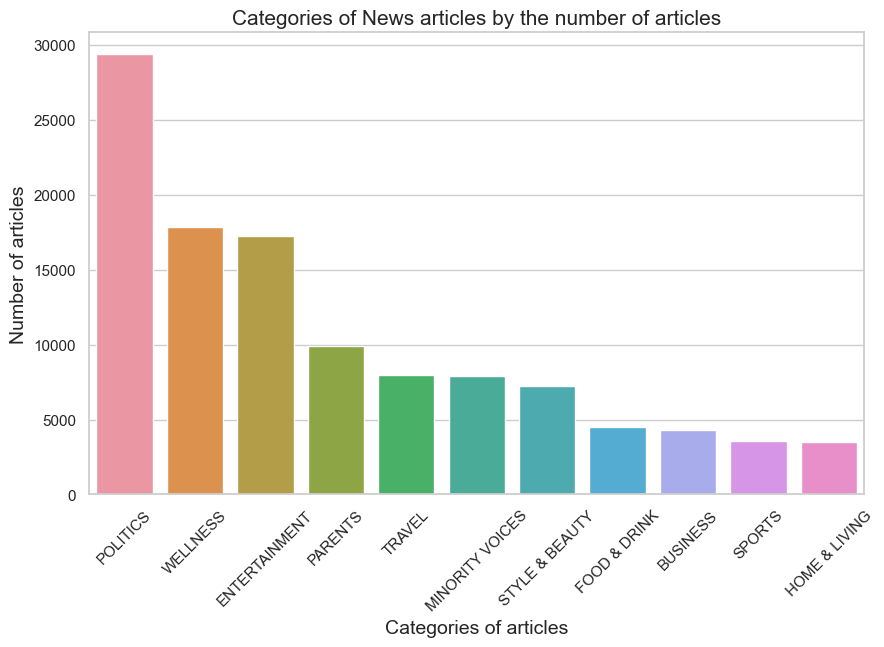

,category,count
0,POLITICS,29373
1,WELLNESS,17826
2,ENTERTAINMENT,17231
3,PARENTS,9918
4,TRAVEL,7953
5,MINORITY VOICES,7937
6,STYLE & BEAUTY,7215
7,FOOD & DRINK,4481
8,BUSINESS,4333
9,SPORTS,3584


In [185]:
# Visualize top 10 categories and proportion of each category's in dataset
plt.figure(figsize=(10,6))
df_sorted = cat_df.sort_values(by='count', ascending=False)
sns.barplot(x='category', y='count', data=df_sorted, order=df_sorted['category'])
plt.title("Categories of News articles by the number of articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()
cat_df

### Authors

In [186]:
#This is taking only the words until the first comma, it destroys few entries where there are two authors separated by comma, but it is not often, so we can leave with that
def extract_text(row):
    comma_index = row.find(',')
    semicolon_index = row.find(';')
    parenthesis_index = row.find('(')
    indices = [index for index in [comma_index, semicolon_index, parenthesis_index] if index != -1]
    if indices:
        min_index = min(indices)
        return row[:min_index]
    else:
        return row

In [187]:
df_authors = df.copy()

In [188]:
# df_authors['ExtractedAuthor'] = df['authors'].apply(extract_text)
# unique authors count
# len(df_authors['ExtractedAuthor'].unique())
# df_authors[['ExtractedAuthor', 'authors']]
# df['authors'] = df['authors'].apply(extract_text)

In [189]:
# Percentage of authors with less than 10 articles
(df['authors'].value_counts() < 10).sum() / df.shape[0] * 100

15.487166818129683

In [190]:
df['authors'].value_counts()

Lee Moran                                                                                          2031
Ron Dicker                                                                                         1633
Cole Delbyck                                                                                       1253
Reuters, Reuters                                                                                   1128
Mary Papenfuss                                                                                     1103
                                                                                                   ... 
Meerabelle Dey, ContributorWriter, columnist for Beliefnet and co-founder of the blog, La...          1
Broderick Johnson, Contributor Assistant to the President and Cabinet Secretary; Chair of th...       1
Paul Loeb, ContributorAuthor, 'Soul of a Citizen' and 'The Impossible Will Take a Li...               1
Kara Sundlun, ContributorNews Anchor, Talk Show Host, Author, Mo

In [191]:
df[df['authors'].str.len() > 50]

,link,headline,category,short_description,authors,date
81,https://www.huffpost.com/entry/biden-student-l...,Student Loan Borrowers Await Biden Plan On Deb...,POLITICS,If Biden's plan survives legal challenges that...,"Seung Min Kim, Michael Balsamo, Chris Megerian...",2022
86,https://www.huffpost.com/entry/after-delay-bid...,"After Delay, Biden Readies Student Loan Help, ...",POLITICS,The precise details of President Joe Biden’s p...,"Seung Min Kim, Michael Balsamo and Chris Meger...",2022
792,https://www.huffpost.com/entry/trump-tweets-ra...,The Best And Worst Trump Tweets Over The Past ...,POLITICS,Here you go.,"Amanda Terkel, Paige Lavender, Richard Kim, an...",2022
1222,https://www.huffpost.com/entry/police-say-they...,Police Say They’re Ready For Rally Supporting ...,POLITICS,The Capitol police are taking no chances as th...,"By Colleen Long, Michael Balsamo and Ashraf Kh...",2021
1298,https://www.huffpost.com/entry/taliban-us-airs...,U.S. Drone Strike Kills Suicide Bombers Target...,POLITICS,The strike hit a vehicle carrying “multiple su...,"Kathy Gannon, Lolita C. Baldor, Tameem Akhgar ...",2021
...,...,...,...,...,...,...
148106,https://www.huffingtonpost.com/entry/gay-divor...,Gay Divorce: How the Collaborative Family Law ...,MINORITY VOICES,One of the many unjust results of a state lega...,"Thomas Greenwald, Contributor\nPartner, Gorans...",2012
148107,https://www.huffingtonpost.com/entry/the-six-p...,Episode 87: Life Is a Highway (AUDIO),MINORITY VOICES,"On this episode of The Six Pack, we hit up the...","The Six Pack, Contributor\nRadio show hosted b...",2012
148111,https://www.huffingtonpost.com/entry/four-more...,Four More Bank Closures Mark the Week of Janua...,BUSINESS,The general pattern of the FDIC closing banks ...,"Dennis Santiago, Contributor\nGlobal Risk and ...",2012
148114,https://www.huffingtonpost.com/entry/world-eco...,"At World Economic Forum, Fear of Global Contag...",BUSINESS,"For decades, as crises have assailed developin...","Peter S. Goodman, Contributor\nExecutive Busin...",2012


In [192]:
# look at the relationship between authors and category
# for top 100 authors
# get top 100 authors
top_100_authors = df['authors'].value_counts()[1:101].index.tolist()
# look at the distribution of categories for each of these authors
df_top_100_authors = df[df['authors'].isin(top_100_authors)]

# Calculate the total number of publications for each author
author_total_publications = df_top_100_authors.groupby('authors').size().sort_values(ascending=False)

df_top_100_authors.groupby(['authors', 'category']).size()

authors                category       
Alana Horowitz Satlin  BUSINESS            16
                       ENTERTAINMENT       16
                       MINORITY VOICES      8
                       PARENTS              1
                       POLITICS           179
                                         ... 
Zach Carter            BUSINESS             1
                       ENTERTAINMENT        3
                       POLITICS           191
Zeba Blay              ENTERTAINMENT       10
                       MINORITY VOICES    173
Length: 423, dtype: int64

In [193]:
# for Elyse Wanshel get the distribution of categories
df[df['authors'] == 'Elyse Wanshel']['category'].value_counts()

ENTERTAINMENT      322
MINORITY VOICES     59
POLITICS            23
PARENTS             18
WELLNESS             7
SPORTS               4
TRAVEL               3
STYLE & BEAUTY       1
BUSINESS             1
Name: category, dtype: int64

<Axes: xlabel='authors'>

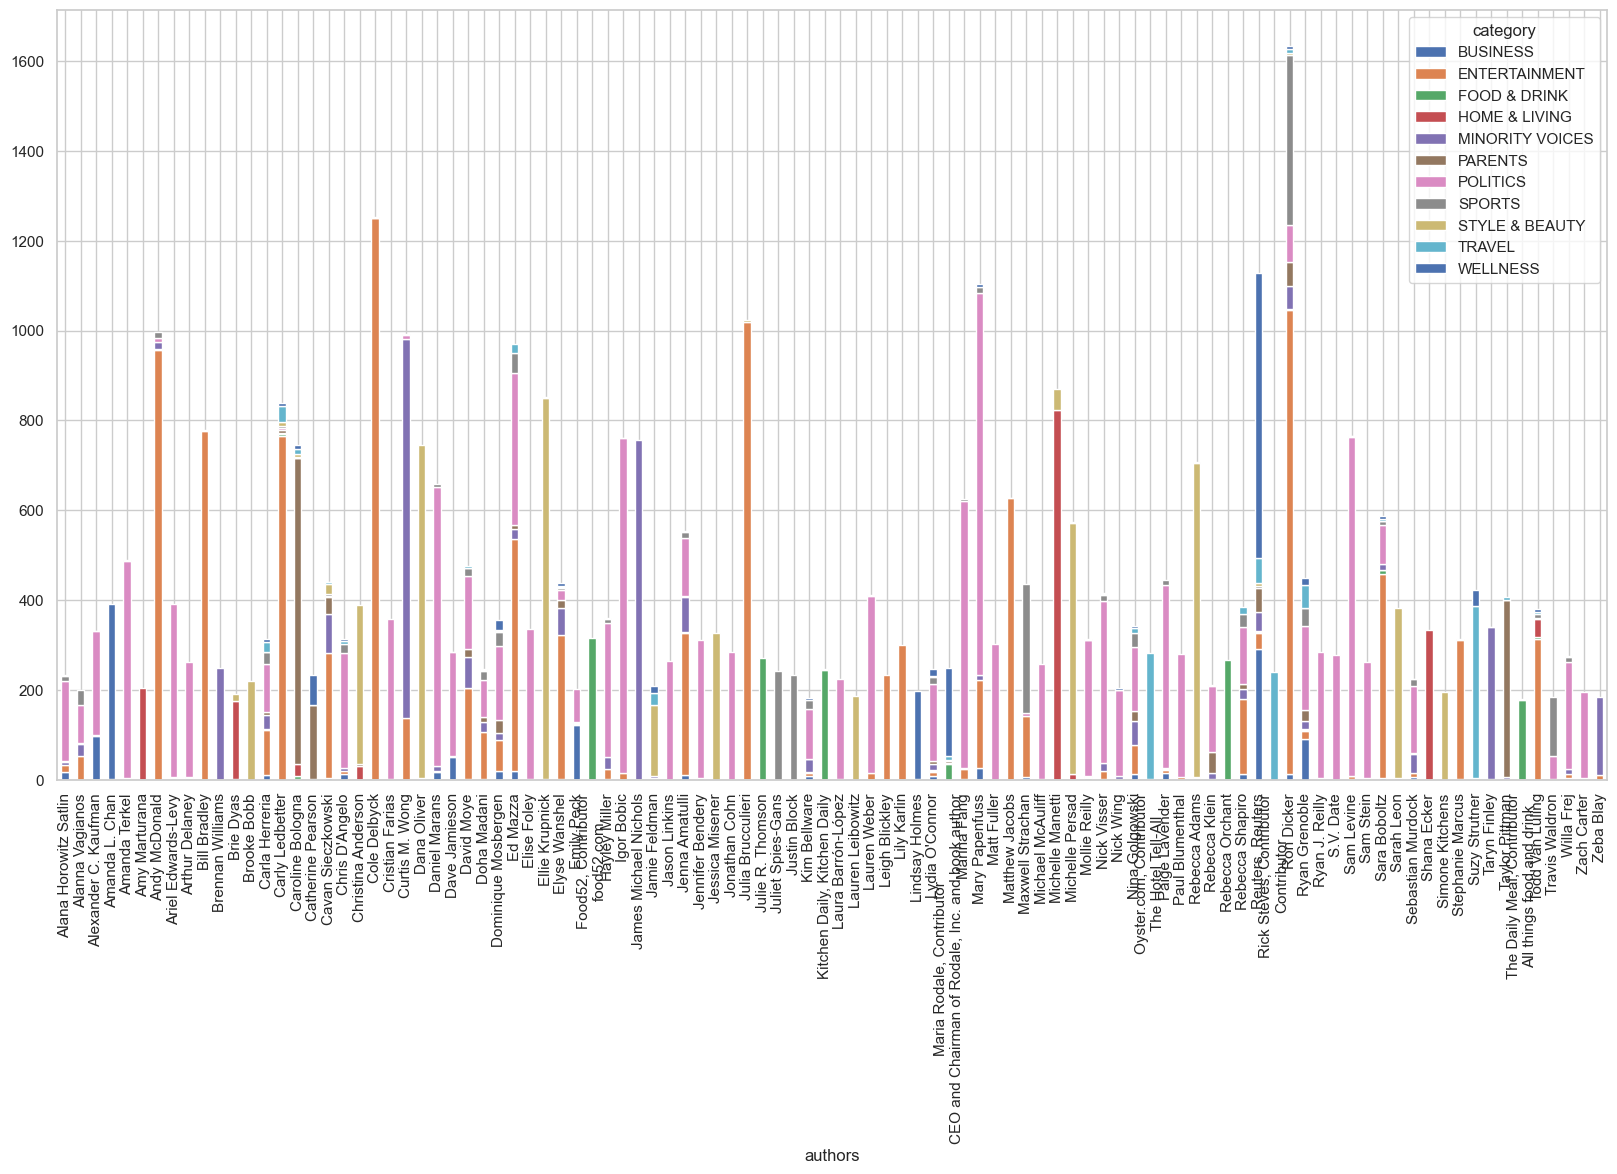

In [194]:
# plot the distribution of categories for top 100 authors
df_top_100_authors.groupby(['authors', 'category']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

Insights:
- Some authors are just names whereas others have descriptions of the author
- Further some other authors are actually institutions rather than individuals
- There are a lot of authors that have more than one article in the dataset - almost 90% of authors have over 10 articles
- Author seems like it could be a useful predictor of Category
- There is a fair amount of missing data! How to resolve this!


### Link

In [195]:
# extract the website name from the link using regex
import re
df['website'] = df['link'].apply(lambda x: re.findall(r'(?<=www.)[^/]+', x)[0])

In [196]:
df['website'].unique().shape[0] / df.shape[0] * 100

0.0017646176514703675

In [197]:
df['website'].value_counts()

huffingtonpost.com    108174
huffpost.com            5165
Name: website, dtype: int64

Insight:
- Link is not useful all links are from huffingtonpost - should've known that :(

### Date

In [198]:
counts = df['date'].value_counts()
cat_df = pd.DataFrame({'date': counts.index, 'count': counts.values})

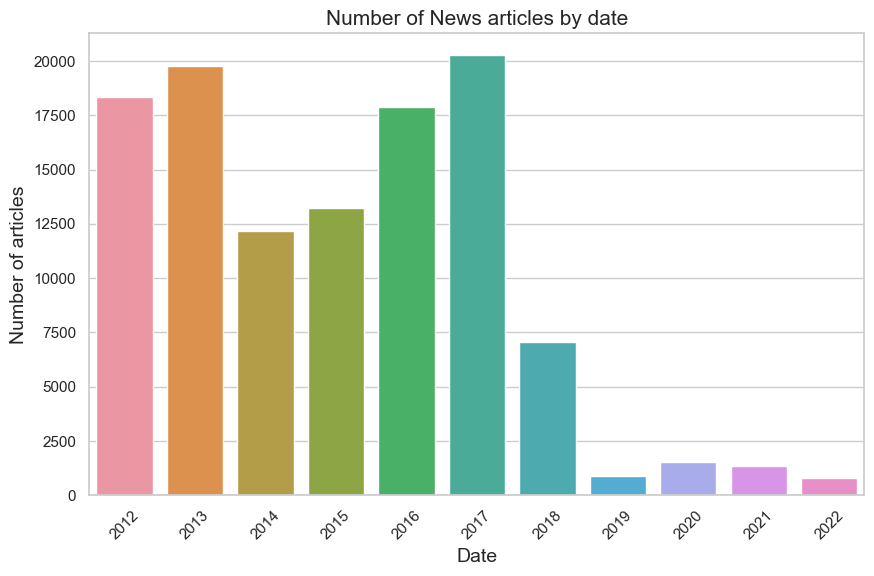

In [199]:
cat_df = cat_df.sort_values(by='date')
plt.figure(figsize=(10,6))
sns.barplot(x='date', y='count', data=cat_df)
plt.title("Number of News articles by date", size=15)
plt.xlabel("Date", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

# Data Wranling

In [43]:
# drop unnecessary features
df.drop(['website'], axis=1, inplace=True)
# no link
df.drop(['link'], axis=1, inplace=True)

In [44]:
df.columns

Index(['headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

In [45]:
# take a sample of the data where we have 10% of the data evenly distributed across categories
df = df.groupby('category').sample(frac=0.1, random_state=42)

# Preprocessing

In [46]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Download necessary resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert text to lowercase

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    preprocessed_text = ' '.join(lemmatized_words)

    # Stemming (uncomment if you want to use stemming)
    # stemmed_words = [stemmer.stem(word) for word in words]
    # preprocessed_text = ' '.join(stemmed_words)

    return preprocessed_text

In [48]:
# Apply the function to preprocess the text
df['headline_clean'] = df['headline'].apply(preprocess_text)
df['short_description_clean'] = df['short_description'].apply(preprocess_text)

In [49]:
# pre-process authors as well
df['authors_clean'] = df['authors'].apply(preprocess_text)

In [50]:
df['headline'].head()

135706    San Bernardino Bankruptcy Caused By Political ...
73169     Chipotle Pork Shortage Is Proof Of A Larger Pr...
78823          Another Step Toward Ecological Seafood Menus
101010    Government Shutdown Halts Logging Industry Pro...
86054     What is the Downtown Podcast? An Interview Wit...
Name: headline, dtype: object

In [51]:
df['headline_clean'].head()

135706    san bernardino bankruptcy caused political feu...
73169     chipotle pork shortage proof larger problem fa...
78823           another step toward ecological seafood menu
101010    government shutdown halt logging industry prod...
86054            downtown podcast interview dylan jorgensen
Name: headline_clean, dtype: object

In [52]:
df['short_description'].head()

135706    Similarly, the problems in the ski resort city...
73169     “We would rather not serve pork at all, than s...
78823     In the seafood trade, you can reassert your ci...
101010    "We're scrambling like everyone else to keep o...
86054     Personally, I think the guests we have had on ...
Name: short_description, dtype: object

In [53]:
df['short_description_clean'].head()

135706    similarly problem ski resort city mammoth lake...
73169     would rather serve pork serve pork animal rais...
78823     seafood trade reassert civic right whether che...
101010    scrambling like everyone else keep head water ...
86054     personally think guest singularity university ...
Name: short_description_clean, dtype: object

In [54]:
df['authors'].head()

135706                                     Reuters, Reuters
73169                                        Jillian Berman
78823     Tim O'Shea, ContributorCEO and co-Founder, Cle...
101010                                     Reuters, Reuters
86054     Phil Simon, ContributorSpeaker, author, professor
Name: authors, dtype: object

In [55]:
df['authors_clean'].head()

135706                                   reuters reuters
73169                                     jillian berman
78823                  tim contributorceo cleanfish fish
101010                                   reuters reuters
86054     phil simon contributorspeaker author professor
Name: authors_clean, dtype: object

## Test and Training Split

In [56]:
df.columns

Index(['headline', 'category', 'short_description', 'authors', 'date',
       'headline_clean', 'short_description_clean', 'authors_clean'],
      dtype='object')

In [57]:
df = df[['headline_clean', 'short_description_clean', 'authors_clean', 'category']]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df[['headline_clean', 'short_description_clean', 'authors_clean']],
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=42
)

# Text Vectorisation

### Chat-GPT which to use?

The choice between word embeddings and TF-IDF (Term Frequency-Inverse Document Frequency) for text vectorization depends on the nature of your NLP task and the characteristics of your data. Here are some considerations for each approach:
Word Embeddings:

    Semantic Relationships:
        Word embeddings capture semantic relationships between words. If your task involves understanding the meaning and context of words, phrases, or documents, word embeddings (such as Word2Vec, GloVe, or embeddings from pre-trained models like BERT) are often more suitable.

    Contextual Information:
        Word embeddings capture contextual information. They take into account the surrounding words in a sentence, which can be crucial for tasks like sentiment analysis, named entity recognition, and part-of-speech tagging.

    Dimensionality Reduction:
        Word embeddings usually result in lower-dimensional representations compared to TF-IDF. This can be beneficial if you have limited computational resources or if you're dealing with high-dimensional data.

    Pre-trained Models:
        If your dataset is not large enough for training high-quality embeddings, pre-trained embeddings (e.g., Word2Vec, GloVe, BERT) can be used. These embeddings are trained on massive corpora and capture rich semantic information.

TF-IDF:

    Bag-of-Words Representation:
        TF-IDF is suitable when you want a simple and efficient bag-of-words representation of your documents. It ignores the order and context of words but can be effective for tasks like text classification, document clustering, or information retrieval.

    Document Importance:
        TF-IDF emphasizes the importance of words in a document relative to their frequency across the entire corpus. This can be beneficial if you want to identify key terms or features that distinguish documents from each other.

    Interpretable Features:
        TF-IDF provides easily interpretable features. Each word is represented by a weight, and these weights indicate the importance of the word in the document.

    Sparse Representations:
        TF-IDF tends to produce sparse representations, which can be advantageous if your dataset is large and you want to conserve memory.

General Recommendations:

    Size of the Dataset:
        For small datasets, pre-trained word embeddings might provide better results since they have been trained on large corpora. For larger datasets, you can experiment with both approaches.

    Task Requirements:
        Consider the specific requirements of your NLP task. If semantic relationships and context are crucial, word embeddings may be more suitable. If you need a simple bag-of-words representation or want to emphasize document-level importance, TF-IDF might be appropriate.

    Experimentation:
        It's often a good idea to experiment with both approaches and evaluate their performance on your specific task. Some tasks may benefit more from one approach over the other.

In practice, it's not uncommon to try both word embeddings and TF-IDF and compare their performance to determine which one works best for a particular NLP task.

Seems to suggest TF-IDF might be appropriate

## TF-IDF Approach

In [59]:
X_train['short_description_clean'].head()

79809     decade united state world status quo power fou...
114078    home story idea tip email u homesubmissions pr...
42375                                legolasting connection
113441    thompson said spirit firmly established safe c...
18990     convincing state legislature go along proving ...
Name: short_description_clean, dtype: object

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Import required libraries
# Model building: Choose and train a classifier
vectorizer = TfidfVectorizer()  # Use TF-IDF vectorizer for text to numerical feature conversion


In [61]:
# attempt to merge features
X_train_vec = vectorizer.fit_transform(X_train['headline_clean'] + ' ' + X_train['short_description_clean'] + ' ' + X_train['authors_clean'])
X_test_vec = vectorizer.transform(X_test['headline_clean'] + ' ' + X_test['short_description_clean'] + ' ' + X_test['authors_clean'])

#### Basic Classification Methods

##### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model (1:14)
logistic_model = LogisticRegression(max_iter=1000) # increase iterations to help with convergence (default is 100)
logistic_model.fit(X_train_vec, y_train)
logistic_predictions = logistic_model.predict(X_test_vec)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("Logistic Regression Accuracy:", logistic_accuracy)

Logistic Regression Accuracy: 0.7704251386321627


6.5 seconds on 10%

In [139]:
# training accuracy
logistic_predictions_train = logistic_model.predict(X_train_vec)
logistic_accuracy_train = accuracy_score(y_train, logistic_predictions_train)
print("Logistic Regression Training Accuracy:", logistic_accuracy_train)

Logistic Regression Training Accuracy: 0.9013863216266174


In [64]:
# Classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, logistic_predictions))

                 precision    recall  f1-score   support

       BUSINESS       0.94      0.29      0.44       115
  ENTERTAINMENT       0.75      0.83      0.79       380
   FOOD & DRINK       0.86      0.67      0.75       124
  HOME & LIVING       0.91      0.55      0.68        91
MINORITY VOICES       0.87      0.51      0.64       198
        PARENTS       0.80      0.70      0.75       241
       POLITICS       0.75      0.95      0.84       643
         SPORTS       0.88      0.31      0.46        97
 STYLE & BEAUTY       0.88      0.80      0.84       188
         TRAVEL       0.84      0.68      0.75       183
       WELLNESS       0.69      0.93      0.79       445

       accuracy                           0.77      2705
      macro avg       0.83      0.66      0.70      2705
   weighted avg       0.79      0.77      0.76      2705



Text(0, 0.5, 'True Positive Rate')

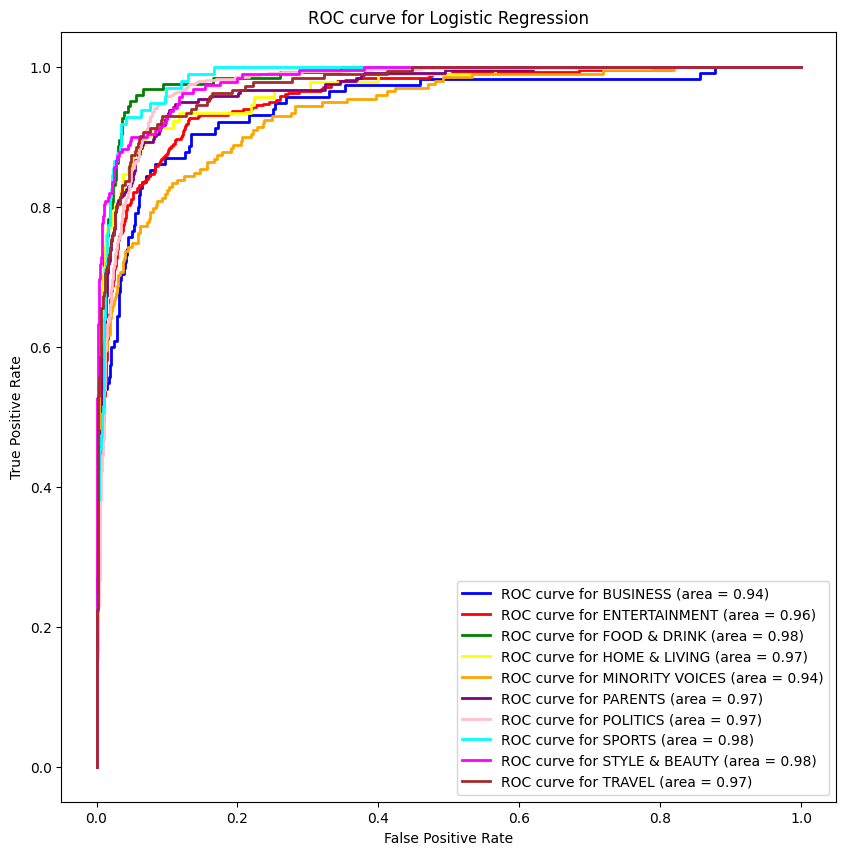

In [65]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# plot the ROC curve
y_test_bin = label_binarize(y_test, classes=logistic_model.classes_)
y_score = logistic_model.decision_function(X_test_vec)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# plot the curves
plt.figure(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'brown']
for (idx, color) in zip(range(n_classes), colors):
    plt.plot(fpr[idx], tpr[idx], color=color, lw=2, label='ROC curve for {} (area = {:.2f})'.format(logistic_model.classes_[idx], roc_auc[idx]))
# add legend
plt.legend(loc='lower right')
# add title and axis labels
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [66]:
# hyperparameter tuning
# C (inverse regularization strength) hyperparameter tuning
# penalty (type of regularization) hyperparameter tuning
# solver (optimization algorithm) hyperparameter tuning
# class_weight (class imbalance) hyperparameter tuning
# max_iter (maximum number of iterations) hyperparameter tuning

# TODO: This doesn't work at the moment - most fits fail
# for now just do C and penalty
# from sklearn.model_selection import GridSearchCV
# # define the grid
# grid = dict()
# grid['C'] = [0.01, 0.1, 1.0]
# grid['penalty'] = ['l1', 'l2', 'elasticnet']
# # define the grid search
# search = GridSearchCV(logistic_model, grid, scoring='accuracy', cv=5, n_jobs=-1)
# # perform the search
# results = search.fit(X_train_vec, y_train)
# # summarize
# print('Mean Accuracy: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

##### KNN

In [67]:
# kNN model
# TODO: cross-validation to find the best k (7:11)
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_vec, y_train)
knn_predictions = knn_model.predict(X_test_vec)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("kNN Accuracy:", knn_accuracy)

kNN Accuracy: 0.7478743068391867


3 seconds on 10%

In [138]:
# training accuracy
knn_predictions_train = knn_model.predict(X_train_vec)
knn_accuracy_train = accuracy_score(y_train, knn_predictions_train)
print("kNN Training Accuracy:", knn_accuracy_train)

kNN Training Accuracy: 0.8122920517560074


KNN prediction on train takes 9 seconds (longer than fitting)

##### Naive Bayes

In [68]:
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_predictions = nb_model.predict(X_test_vec)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.5866913123844733


In [137]:
# training accuracy
nb_predictions_train = nb_model.predict(X_train_vec)
nb_accuracy_train = accuracy_score(y_train, nb_predictions_train)
print("Naive Bayes Training Accuracy:", nb_accuracy_train)

Naive Bayes Training Accuracy: 0.7011090573012939


0.1 second on 10%

##### SVM

In [70]:
# SVM model
# from sklearnex import patch_sklearn 
# patch_sklearn()
from sklearn.svm import SVC
svm_model = SVC(C=100, kernel='rbf') # default kernel is rbf and default C is 1.0
# TODO: cross-validation to find the best C and kernel
svm_model.fit(X_train_vec, y_train)
svm_predictions = svm_model.predict(X_test_vec)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.7859519408502773


1 min 20 on 10%

In [136]:
# training accuracy
svm_predictions_train = svm_model.predict(X_train_vec)
svm_accuracy_train = accuracy_score(y_train, svm_predictions_train)
print("SVM Training Accuracy:", svm_accuracy_train)

SVM Training Accuracy: 0.9999075785582255


SVM prediction takes 37 seconds on train

##### Decision Tree

In [71]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_vec, y_train)
predicted_dt = dt.predict(X_test_vec)
accuracy_dt = accuracy_score(y_test, predicted_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.6303142329020333


15 seconds on 10%

In [135]:
# training accuracy
predicted_dt_train = dt.predict(X_train_vec)
accuracy_dt_train = accuracy_score(y_train, predicted_dt_train)
print("Decision Tree Training Accuracy:", accuracy_dt_train)

Decision Tree Training Accuracy: 0.9999075785582255


##### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
predicted_rf = rf.predict(X_test_vec)
accuracy_rf = accuracy_score(y_test, predicted_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.744177449168207


1 min 40 on 10%

In [134]:
# training accuracy
predicted_rf_train = rf.predict(X_train_vec)
accuracy_rf_train = accuracy_score(y_train, predicted_rf_train)
print("Random Forest Training Accuracy:", accuracy_rf_train)

Random Forest Training Accuracy: 0.9999075785582255


##### Bagging

In [73]:
# Random Forest model
from sklearn.ensemble import BaggingClassifier

model_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=14, random_state=8678686)
model_bagging.fit(X_train_vec, y_train)
pred_bagging = model_bagging.predict(X_test_vec)
result_bagging = accuracy_score(y_test, pred_bagging)
print("Bagging Accuracy:", result_bagging)

Bagging Accuracy: 0.6805914972273568


2 min 40 run time on 10%

In [133]:
# training accuracy
pred_bagging_train = model_bagging.predict(X_train_vec)
result_bagging_train = accuracy_score(y_train, pred_bagging_train)
print("Bagging Training Accuracy:", result_bagging_train)

Bagging Training Accuracy: 0.9881700554528651


##### Boosting

Attempting Gradient Boosting classification (a boosting method)

In [74]:
# Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_vec, y_train)
gb_predictions = gb_model.predict(X_test_vec)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

Gradient Boosting Accuracy: 0.7375231053604436


11 min run time on 10%

In [129]:
# train accuracy
gb_predictions_train = gb_model.predict(X_train_vec)
gb_accuracy_train = accuracy_score(y_train, gb_predictions_train)
print("Gradient Boosting Training Accuracy:", gb_accuracy_train)

Gradient Boosting Training Accuracy: 0.8635859519408503


##### AdaBoosting

In [75]:
from sklearn.ensemble import AdaBoostClassifier


model_boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=8678686)
model_boosting.fit(X_train_vec, y_train)
pred_boosting = model_boosting.predict(X_test_vec)
result_boosting = accuracy_score(y_test, pred_boosting)
print("AdaBoosting Accuracy:", result_boosting)

Boosting Accuracy: 0.6502772643253235


17 min on 10%

In [85]:
adaboost_accuracy = result_boosting

In [132]:
# train accuracy
pred_boosting_train = model_boosting.predict(X_train_vec)
result_adaboost_train = accuracy_score(y_train, pred_boosting_train)
print("AdaBoosting Training Accuracy:", result_adaboost_train)

AdaBoosting Training Accuracy: 0.9999075785582255


##### XGBoosting

In [76]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.fit_transform(y_test)
model_xgb = XGBClassifier()
model_xgb.fit(X_train_vec, y_encoded_train)
pred_xgb = model_xgb.predict(X_test_vec)
result_xgb = accuracy_score(y_encoded_test, pred_xgb)
print("XGBoost Accuracy:", result_xgb)

XGBoost Accuracy: 0.766728280961183


19 seconds on 10%

In [126]:
# train accuracy
pred_xgb_train = model_xgb.predict(X_train_vec)
result_xgb_train = accuracy_score(y_encoded_train, pred_xgb_train)
print("XGBoost Training Accuracy:", result_xgb_train)

XGBoost Training Accuracy: 0.9440850277264325


##### Neural Network

In [77]:
# Neural Network model
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier()
nn_model.fit(X_train_vec, y_train)
nn_predictions = nn_model.predict(X_test_vec)
nn_accuracy = accuracy_score(y_test, nn_predictions)
print("Neural Network Accuracy:", nn_accuracy)

Neural Network Accuracy: 0.8133086876155268


17 minutes on 10%

In [125]:
# train accuracy
nn_predictions_train = nn_model.predict(X_train_vec)
nn_accuracy_train = accuracy_score(y_train, nn_predictions_train)
print("Neural Network Training Accuracy:", nn_accuracy_train)

Neural Network Training Accuracy: 0.9999075785582255


#### Majority Classifier

In [124]:
# majority in training set
majority_category = y_train.value_counts().idxmax()
accuracy_majority_train = accuracy_score(y_train, [majority_category]*len(y_train))
# majority in test set
accuracy_majority = accuracy_score(y_test, [majority_category]*len(y_test))
print("Majority classifier Training Accuracy:", accuracy_majority_train)
print("Majority classifier Test Accuracy:", accuracy_majority)

Majority classifier Training Accuracy: 0.23724584103512014
Majority classifier Test Accuracy: 0.2377079482439926


# Performance Comparison

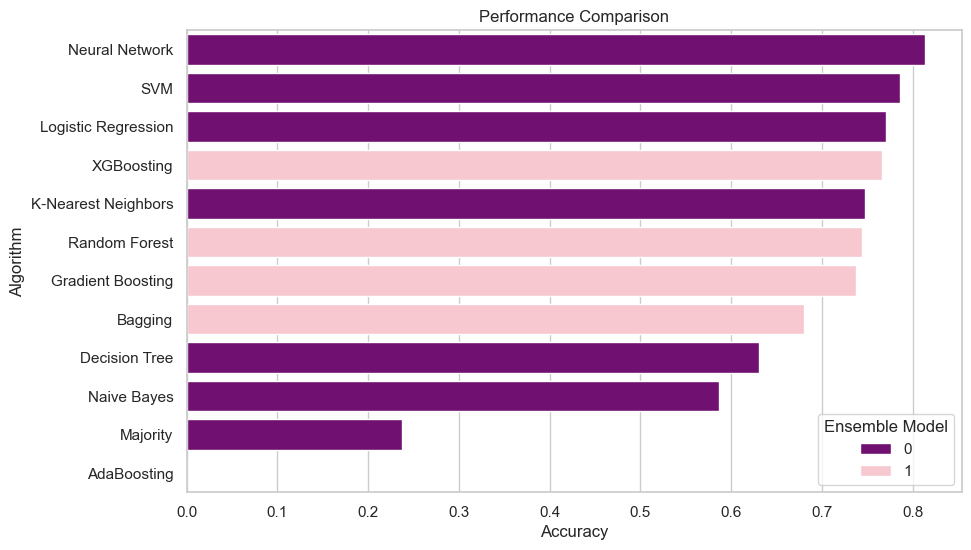

In [79]:
algo_names = ["Majority", "Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "SVM", "Decision Tree", "Random Forest", "Bagging", "Gradient Boosting", "AdaBoosting", "XGBoosting", "Neural Network"]
performances = [accuracy_majority, logistic_accuracy, knn_accuracy, nb_accuracy, svm_accuracy, accuracy_dt, accuracy_rf, result_bagging, gb_accuracy, 0, result_xgb, nn_accuracy] #TODO: Change 0 to result_boosting
ensemble_model = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]

result_df = pd.DataFrame({'Algorithm': algo_names, 'Performance': performances, 'Ensemble Model': ensemble_model})
result_df = result_df.sort_values(by='Performance', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Performance', y='Algorithm', hue='Ensemble Model', data=result_df, dodge=False, palette={0: 'purple', 1: 'pink'})
plt.xlabel('Accuracy')
plt.ylabel('Algorithm') 
plt.title('Performance Comparison')
plt.legend(title='Ensemble Model', loc='lower right')
plt.show()

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [152]:
algo_names = ["Majority", "Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "SVM", "Decision Tree", "Random Forest", "Bagging", "Gradient Boosting", "AdaBoosting", "XGBoosting", "Neural Network"]*2
test_performances = [accuracy_majority, logistic_accuracy, knn_accuracy, nb_accuracy, svm_accuracy, accuracy_dt, accuracy_rf, result_bagging, gb_accuracy, adaboost_accuracy, result_xgb, nn_accuracy]
train_performances = [accuracy_majority_train, logistic_accuracy_train, knn_accuracy_train, nb_accuracy_train, svm_accuracy_train, accuracy_dt_train, accuracy_rf_train, result_bagging_train, gb_accuracy_train, result_adaboost_train, result_xgb_train, nn_accuracy_train]
performance_set = ['Test']*12 + ['Train']*12
performances = test_performances + train_performances
ensemble_model = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]*2

result_df = pd.DataFrame({'Algorithm': algo_names, 'Performance': performances, 'performance_set': performance_set, 'Ensemble Model': ensemble_model})
result_df = result_df.sort_values(by='Performance', ascending=False)

In [153]:
# order the algorithms by the performance on the test set
algo_names = result_df[result_df['performance_set'] == 'Test']['Algorithm'].tolist()
# sort the df by the order of algo_names
result_df['Algorithm'] = pd.Categorical(result_df['Algorithm'], categories=algo_names, ordered=True)

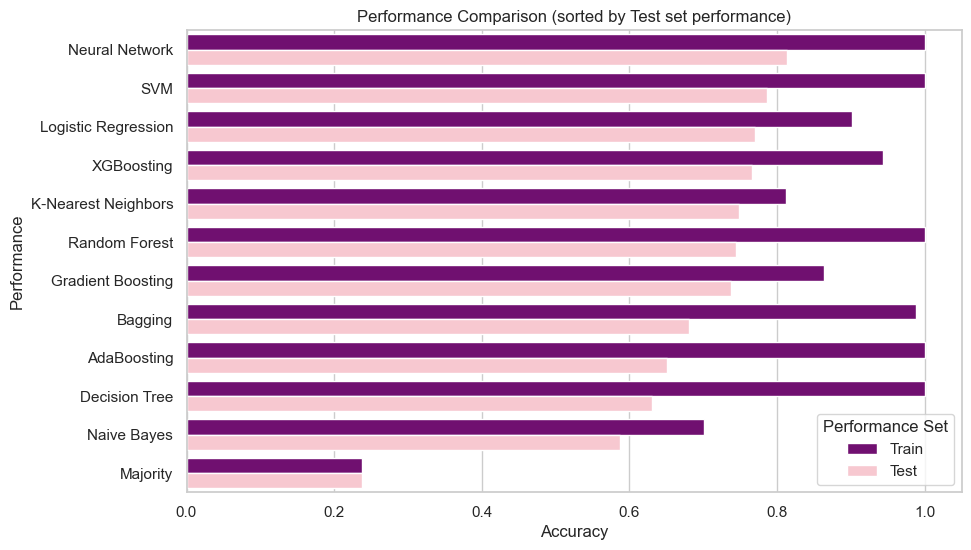

In [158]:
# plot a grouped bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(y='Algorithm', x='Performance', hue='performance_set', data=result_df, dodge=True, palette={'Train': 'purple', 'Test': 'pink'})
plt.xlabel('Accuracy')
plt.ylabel('Performance')
plt.title('Performance Comparison (sorted by Test set performance)')
plt.legend(title='Performance Set', loc='lower right')
plt.show()

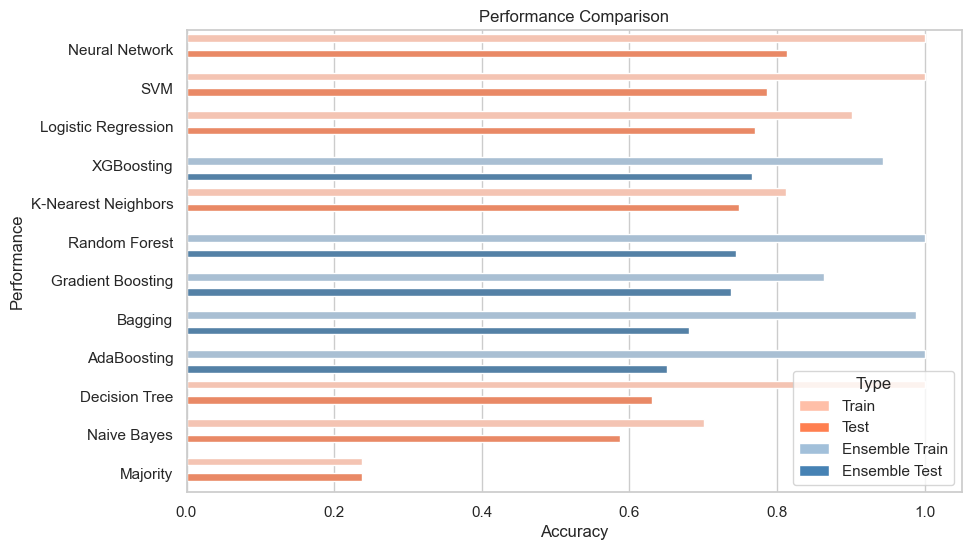

In [159]:
# Define a function to lighten the color
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1 - amount) to each channel.
    """
    import matplotlib.colors as mcolors
    color_rgb = mcolors.hex2color(color)
    new_color = [min(1, c + (1 - c) * amount) for c in color_rgb]
    return mcolors.to_hex(new_color)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# combine ensemble and performance set columns
result_df['performance_set_ensemble'] = result_df.apply(lambda row: row['performance_set'] + '_' + str(row['Ensemble Model']), axis=1)

# Use 'palette' to specify the colors for 'Train' and 'Test' sets
sns.barplot(y='Algorithm', 
            x='Performance', 
            hue='performance_set_ensemble', 
            data=result_df, 
            dodge=True, 
            palette={'Train_0': lighten_color('coral'), 'Test_0': 'coral',
                     'Train_1': lighten_color('steelblue'), 'Test_1': 'steelblue'})
plt.xlabel('Accuracy')
plt.ylabel('Performance')
plt.title('Performance Comparison')
plt.legend(title='Type', loc='lower right', 
           labels=['Train', 'Test', 'Ensemble Train', 'Ensemble Test'],
           handles = [plt.Rectangle((0,0),1,1,fc=lighten_color('coral')), plt.Rectangle((0,0),1,1,fc='coral'),
                      plt.Rectangle((0,0),1,1,fc=lighten_color('steelblue')), plt.Rectangle((0,0),1,1,fc='steelblue')])
plt.show()
